In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import math
sys.path.append('../')
from Scattering_Simulator import pairwise_method

In this notebook we will validate the MC-DFM method on the scattering of a core shell cylinder, where the core and shell have different scattering length densities. 

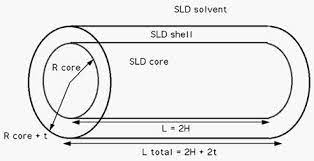

We first define a function used to mathematically model the core shell cylinder.

In [25]:
def circle_coord(r, low, high, dist):
    for i in range(len(r)):
        circumference = 2*np.pi*r[i]
        n = int(np.round(circumference/dist))
        theta = np.linspace(low, high, n)
        x = r[i]*np.cos(theta).reshape(-1,1)
        y = r[i]*np.sin(theta).reshape(-1,1)
        if i == 0:
            x_array = x
            y_array = y
        else:
            x_array = np.vstack((x_array, x))
            y_array = np.vstack((y_array, y))
    return x_array, y_array


## Create Core Shell Cylinder

We will try to simulate a cylinder with 12A in diameter and 30A in length. The inner cylinder (core), of 9A in diameter, will have a SLD of 1. The outer cylinder (shell), of 10-12 A in diamter will have a SLD of 2. 

Text(0.5, 1.0, 'Cross Section of the Core Shell Cylinder')

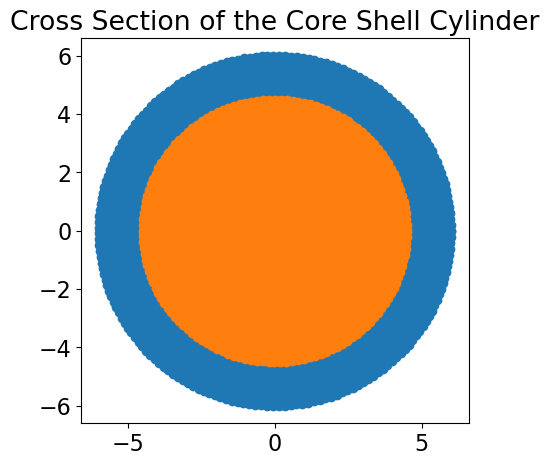

In [40]:
r = np.linspace(4.5, 6, 10)
#r = np.array([5,5.5,6])
low = 0
high = 2*3.14
dist = 0.2
x_outer, y_outer = circle_coord(r, low, high, dist)

r = np.linspace(0, 4.5, 30)
#r = np.array([0.1,0.5,1,1.5,2,2.5,3,3.5,4,4.5])
x_inner, y_inner = circle_coord(r, low, high, dist)

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 16})
plt.scatter(x_outer, y_outer)
plt.scatter(x_inner, y_inner)
plt.title('Cross Section of the Core Shell Cylinder')
#plt.savefig('../Figures/RhuA/Helix_Coordinates.png', dpi=300, bbox_inches="tight")

We then create the "Caps" of the cylinder which have the same SLD as the shell

In [32]:
SLD_outer = 4
z_outer = np.array([0]*len(x_outer)).reshape(-1,1)
z_inner = np.array([0]*len(x_inner)).reshape(-1,1)
sld_outer = np.array([SLD_outer]*len(x_outer)).reshape(-1,1)
sld_inner = np.array([1]*len(x_inner)).reshape(-1,1)
outer_coord = np.hstack((x_outer, y_outer, z_outer, sld_outer))
inner_coord = np.hstack((x_inner, y_inner, z_inner, sld_inner))
coordinates = np.vstack((inner_coord, outer_coord))
z_direction = np.linspace(0, 30, 61)

coordinates = inner_coord
for i in range(len(z_direction)):
    coord_z = coordinates[:,2] + z_direction[i]
    coord_z = coord_z.reshape(-1,1)
    new_coord = np.hstack((coordinates[:,0].reshape(-1,1), coordinates[:,1].reshape(-1,1), coord_z.reshape(-1,1), coordinates[:,-1].reshape(-1,1)))
    if i == 0:
        cylinder_coord = new_coord
    else:
        cylinder_coord = np.vstack((cylinder_coord, new_coord))
core = cylinder_coord  
      
coordinates = outer_coord
for i in range(len(z_direction)):
    coord_z = coordinates[:,2] + z_direction[i]
    coord_z = coord_z.reshape(-1,1)
    new_coord = np.hstack((coordinates[:,0].reshape(-1,1), coordinates[:,1].reshape(-1,1), coord_z.reshape(-1,1), coordinates[:,-1].reshape(-1,1)))
    if i == 0:
        cylinder_coord = new_coord
    else:
        cylinder_coord = np.vstack((cylinder_coord, new_coord))
shell = cylinder_coord


Text(0.5, 1.0, 'First Cap of the Core Shell Cylinder')

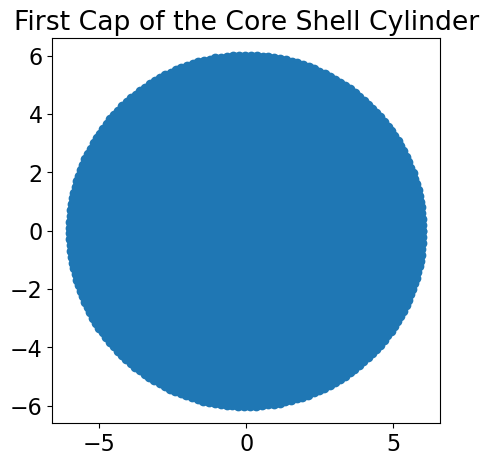

In [37]:
r1 = np.linspace(4.5, 6, 10).reshape(-1,1)
r2 = np.linspace(0, 4.5, 30).reshape(-1,1)
r = np.vstack((r1, r2))
x_cap, y_cap = circle_coord(r, low, high, dist)
fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 16})
plt.scatter(x_cap, y_cap)
plt.title('First Cap of the Core Shell Cylinder')

In [9]:
cap_thickness = -1.5 #1.5 thickness 
z_cap = np.array([cap_thickness]*len(x_cap)).reshape(-1,1)
sld_cap = np.array([SLD_outer]*len(x_cap)).reshape(-1,1)
cap_coord_1 = np.hstack((x_cap, y_cap, z_cap, sld_cap))

cap_thickness = -1 #1.5 thickness 
z_cap = np.array([cap_thickness]*len(x_cap)).reshape(-1,1)
cap_coord_2 = np.hstack((x_cap, y_cap, z_cap, sld_cap))

cap_thickness = -.5 #1.5 thickness 
z_cap = np.array([cap_thickness]*len(x_cap)).reshape(-1,1)
cap_coord_3 = np.hstack((x_cap, y_cap, z_cap, sld_cap))

cap_coordinates_front = np.vstack((cap_coord_1, cap_coord_2, cap_coord_3))



cap_thickness = 30.5 #1.5 thickness 
z_cap = np.array([cap_thickness]*len(x_cap)).reshape(-1,1)
cap_coord_1 = np.hstack((x_cap, y_cap, z_cap, sld_cap))

cap_thickness = 31 #1.5 thickness 
z_cap = np.array([cap_thickness]*len(x_cap)).reshape(-1,1)
cap_coord_2 = np.hstack((x_cap, y_cap, z_cap, sld_cap))

cap_thickness = 31.5 #1.5 thickness 
z_cap = np.array([cap_thickness]*len(x_cap)).reshape(-1,1)
cap_coord_3 = np.hstack((x_cap, y_cap, z_cap, sld_cap))

cap_coordinates_end = np.vstack((cap_coord_1, cap_coord_2, cap_coord_3))


Text(0.5, 1.0, 'Second Cap of the Core Shell Cylinder')

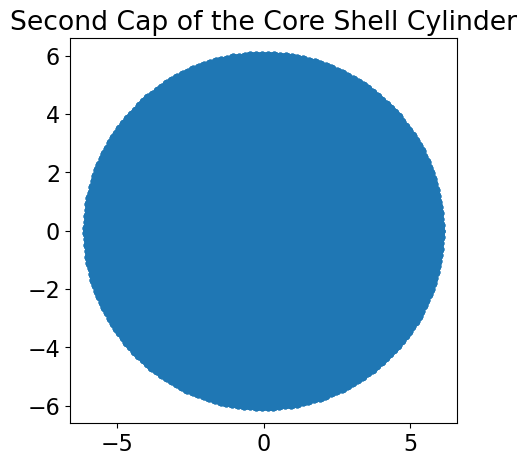

In [38]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(cap_coordinates_front[:,0], cap_coordinates_front[:,1])
plt.title('Second Cap of the Core Shell Cylinder')

In [43]:
shell = np.vstack((shell, cap_coordinates_end, cap_coordinates_front))
core = core

Text(0.5, 1.0, 'Core Shell Cylinder')

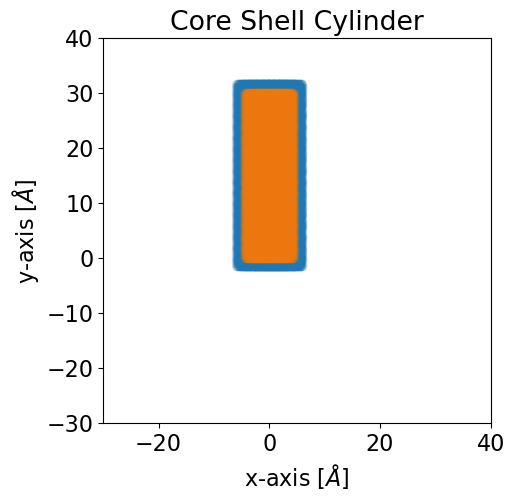

In [49]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(shell[:,0][::5], shell[:,2][::5], alpha = 0.05, label = 'shell')
plt.scatter(core[:,0][::5], core[:,2][::5], alpha = 0.05, label = 'core')
plt.xlim([-30,40])
plt.ylim([-30,40])
plt.xlabel('x-axis [$\AA$]')
plt.ylabel('y-axis [$\AA$]')
plt.title('Core Shell Cylinder')
#plt.savefig('../Figures/RhuA/contrast_variation_tube_radius.png', dpi=300, bbox_inches="tight")

## Randomy sample from core and shell considering the volume of each structrure

We will try to simulate a cylinder with 12A in diameter and 30A in length. The inner cylinder (core), of 9A in diameter, will have a SLD of 1. The outer cylinder (shell), of 12 A in diamter will have a SLD of 2. 

- core diameter: 9
- core length: 30

- core + shell diameter: 12
- core + shell length: 33
- thickness = 1.5

In [13]:
total_volume = 6**2*np.pi*33
core_volume = 4.5**2*np.pi*30
shell_volume = total_volume - core_volume

In [14]:
core_volume/shell_volume

1.0465116279069766

randomly sample points from the core and shell separately, with n_samples determined by the ratios of the volumes

In [15]:
n_core = 1000000
rand_num = np.random.randint(0, len(core), n_core)
coordinates_core = core[rand_num, :]

In [16]:
n_shell = int(np.round(n_core*shell_volume/core_volume))
rand_num = np.random.randint(0, len(shell), n_shell)
coordinates_shell = shell[rand_num, :]

In [17]:
coordinates = np.vstack((coordinates_core, coordinates_shell))

## Sample from the Building Block

In [18]:
n_samples = 10000000
coordinates = coordinates

In [19]:
simulator = pairwise_method.scattering_simulator(n_samples)
simulator.sample_building_block(coordinates)
#erase_coordinates
#coordinates = 0

## Sample from the Structure (Building Block + Lattice)

In [20]:
simulator.use_building_block_as_structure()

## Simulate the Scattering Curve

In [21]:
histogram_bins = 7000
q = np.geomspace(0.004, 10, 6000)
I_q_nonuniform = simulator.simulate_scattering_curve(histogram_bins, q, save=True)

## Plot the Results

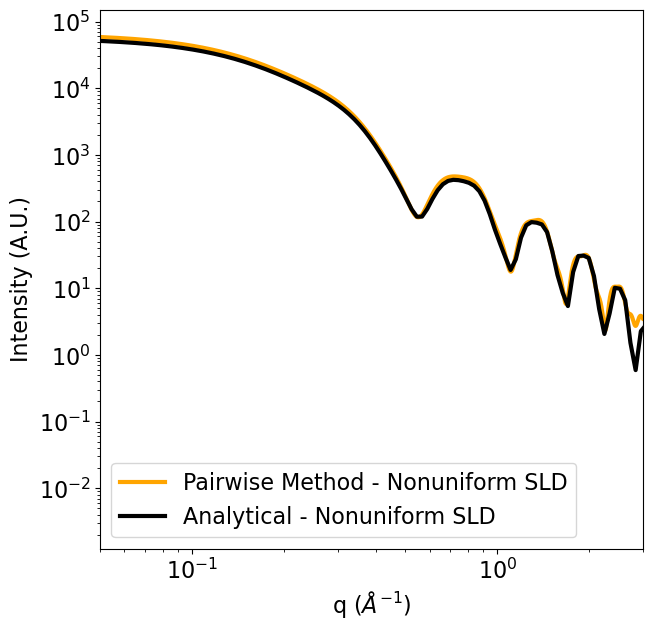

In [24]:
analytical = np.genfromtxt('../Data/scattering/core_shell_cylinder_SLD4_shell_core_1.txt', delimiter=' ', dtype=None)
analytical_const_SLD = np.genfromtxt('../Data/scattering/core_shell_cylinder_constant_SLD.txt', delimiter=' ', dtype=None)
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(7,7))

background = 0e2
plt.plot(q, I_q_nonuniform*1.7e-2 + 1e0, linewidth = 3, label = 'Pairwise Method - Nonuniform SLD', color = 'orange')
plt.plot(analytical[:,0], analytical[:,2]*2.5e4, linewidth = 3, label = 'Analytical - Nonuniform SLD', color ='k')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Intensity (A.U.)')
plt.xlabel('q ($\AA^{-1}$)')
ax.minorticks_on()
plt.xlim([0.05, 3])
plt.legend()